<a href="https://colab.research.google.com/github/bilalProgTech/mtech-nmims/blob/master/deep-learning/Lab-Work/20220911-Lab-7-MTech-DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d adityajn105/flickr8k
!unzip *.zip

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
caption_df = pd.read_csv('/content/captions.txt')
caption_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
caption_df['image'] = '/content/Images/' + caption_df['image']
caption_df.head()

,image,caption
0,/content/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,/content/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,/content/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,/content/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,/content/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
sample_df = caption_df.sample(16)
files = sample_df['image'].tolist()
caption_list = sample_df['caption'].tolist()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from textwrap import wrap

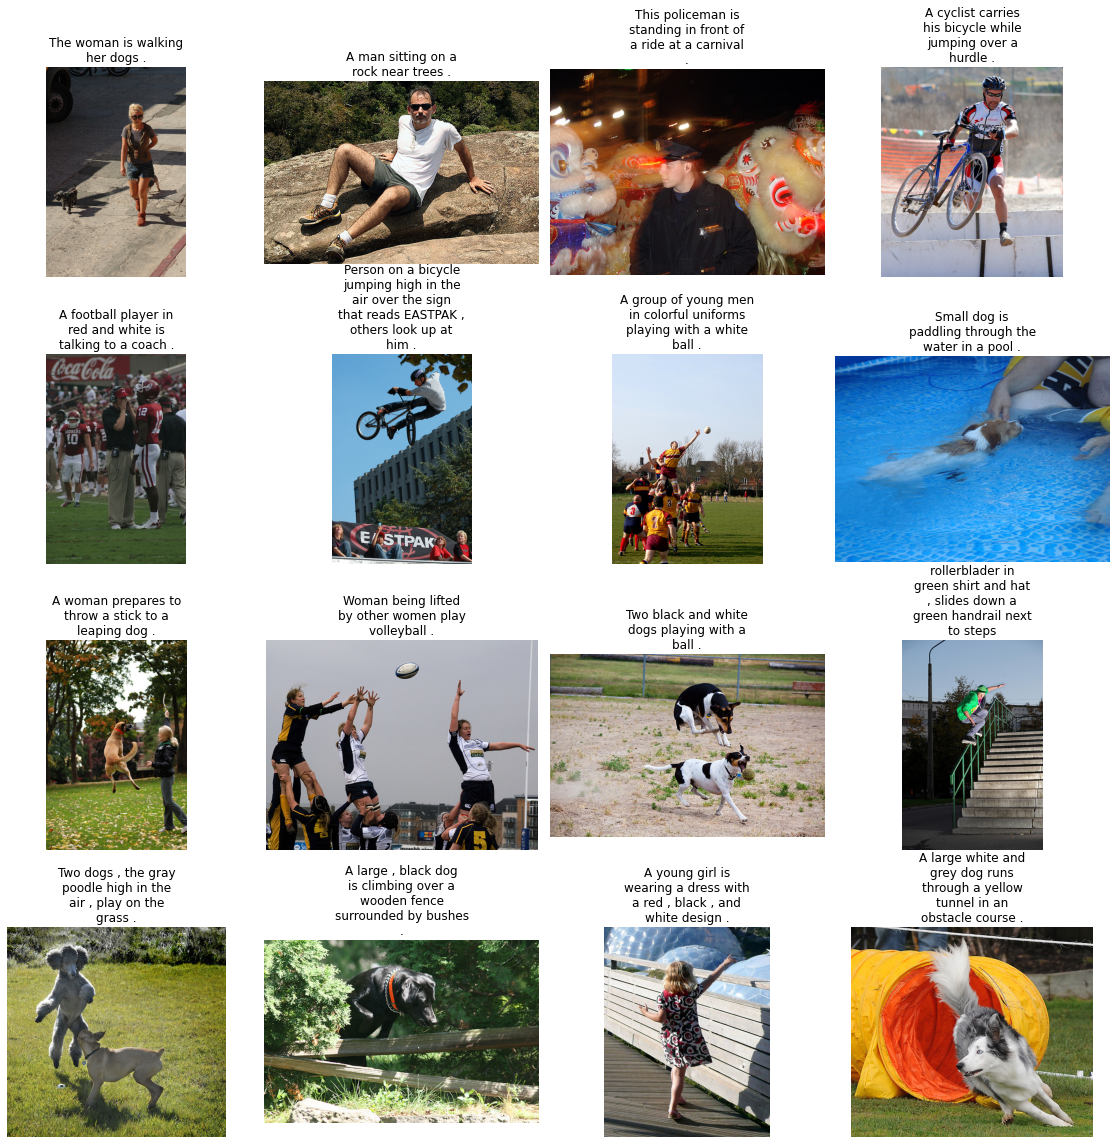

In [ ]:
nrows = 4
ncols = 4
fig = plt.gcf()
fig.set_size_inches(nrows * 4, nrows * 4)

for i, (img_path, caption) in enumerate(zip(files, caption_list)):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title('\n'.join(wrap(caption, 20)))

plt.tight_layout()
plt.show()

In [ ]:
caption_df.shape

(40455, 2)

In [ ]:
len(caption_df['image'].unique())

8091

In [ ]:
import re

In [ ]:
def preprocess_caption(text):
    text = text.lower()
    text = re.sub('[^A-Za-z]', ' ', text)
    text = ' '.join([word for word in text.split() if len(word)>1])
    text = 'startseq ' + text + ' endseq'
    return text

In [ ]:
caption_df['caption'] = caption_df['caption'].apply(lambda x: preprocess_caption(x))
caption_df.head()

,image,caption
0,/content/Images/1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,/content/Images/1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,/content/Images/1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,/content/Images/1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,/content/Images/1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...


In [ ]:
captions = caption_df['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

    child                is
    child is             pink
    child is pink        dress
    child is pink dress  is



In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [ ]:
vocab_size

8427

In [ ]:
max_length

35

In [ ]:
unique_images = caption_df['image'].unique().tolist()
split_factor = round(0.8 * len(unique_images))

train_images = unique_images[:split_factor]
test_images = unique_images[split_factor:]

train = caption_df[caption_df['image'].isin(train_images)].reset_index(drop=True)
test = caption_df[caption_df['image'].isin(test_images)].reset_index(drop=True)

train.shape, test.shape

((32365, 2), (8090, 2))

In [ ]:
from tqdm import tqdm

In [ ]:
from keras.applications.xception import Xception

In [ ]:
tf.keras.backend.clear_session()
cnn_model = Xception(include_top=False)

image_size = 299
features = {}
for image in tqdm(unique_images):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(image_size, image_size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)

    feature = cnn_model.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [11:04<00:00, 12.18it/s]


In [ ]:
from pickle import dump, load

In [ ]:
dump(features, open('xception_features.p','wb'))

In [ ]:
features = load(open('xception_features.p', 'rb'))

In [ ]:
len(features)

8091

In [ ]:
features[0].shape

In [ ]:
def get_model_input(df):
    X_feature, X_seq, y = list(), list(), list()
    images = df['image'].tolist()

    for image in images:
        feature = features[image][0]
        captions = df.loc[df['image']==image, 'caption'].tolist()
        for caption in captions:
            sequence = tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(sequence)):
                in_sequence, out_sequence = sequence[:i], sequence[i]
                in_sequence = tf.keras.preprocessing.sequence.pad_sequences([in_sequence], maxlen=max_length)[0]
                out_sequence = tf.keras.utils.to_categorical([out_sequence], num_classes=vocab_size)[0]
                X_feature.append(feature)
                X_seq.append(in_sequence)
                y.append(out_sequence)

    X_feature, X_seq, y = np.array(X_feature), np.array(X_seq), np.array(y)
    return X_feature, X_seq, y